Project of Kakapo

In [1]:
#Import all necessary libraries
from os.path import join
import tifffile as tiff
import numpy as np
from glob import glob
from shutil import copy2
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.optim as optim
import os
import monai
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.networks.utils import one_hot
from monai.transforms import Compose, ThresholdIntensityd, EnsureChannelFirstd, ScaleIntensityRanged, RandRotate90d, RandFlipd,ResizeWithPadOrCropd,CastToTyped
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

Loaded 505 samples from AC/train/ and train/
Loaded 218 samples from AC/val/ and val/
Loaded 1 samples from AC/Test/ and Test/


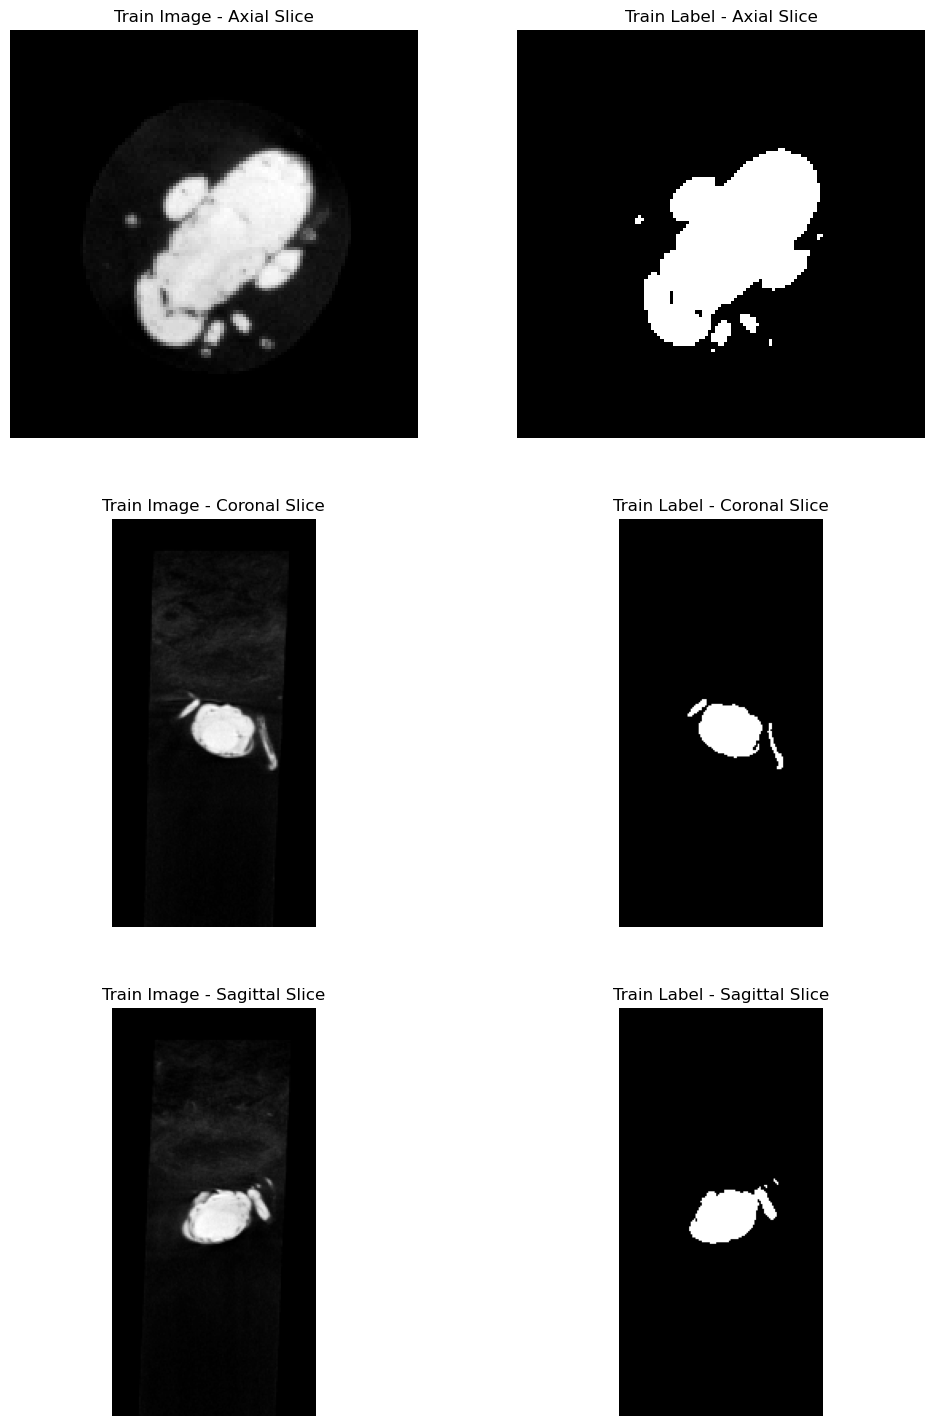

In [2]:
#File path
# DATA_PATH  = '/dtu/3d-imaging-center/courses/02510/groups/group_Kakapo/Project/Manual_label/'
# IMAGE_DIRS = {'train': 'images/train/', 'val': 'images/val/', 'test': 'images/test/'}
# LABEL_DIRS = {'train': 'labels/train/', 'val': 'labels/val/', 'test': 'labels/test/'}

DATA_PATH  = '/dtu/3d-imaging-center/courses/02510/groups/group_Kakapo/Project/bug_256/'
IMAGE_DIRS = {'train': 'AC/train/', 'val': 'AC/val/', 'test': 'AC/Test/'}
LABEL_DIRS = {'train': 'train/', 'val': 'val/', 'test': 'Test/'}


# Helper function to load images and labels dynamically
def load_dataset(image_dir, label_dir):
    image_files = sorted(glob(join(DATA_PATH, image_dir, '*.tif')))
    label_files = sorted(glob(join(DATA_PATH, label_dir, '*.tif')))

    if not image_files or not label_files:
        print(f"Failed to load data from {image_dir} or {label_dir}")
        return None
    
    data = [{'image': tiff.imread(img_path), 'label': tiff.imread(lbl_path)}
            for img_path, lbl_path in zip(image_files, label_files)]
    
    print(f"Loaded {len(data)} samples from {image_dir} and {label_dir}")
    
    return data

#Fuction use for plot example image and label
def plot_3d_slices(data, title):
    if data is None or not data:
        print(f"No data to plot for {title}")
        return
    
    # Randomly select an image
    sample = random.choice(data)
    image = sample['image']
    label = sample['label']
    
    # Calculate middle slices
    slice_x = image.shape[0] // 2
    slice_y = image.shape[1] // 2
    slice_z = image.shape[2] // 2

    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    axes[0, 0].imshow(image[slice_x, :, :], cmap='gray')
    axes[0, 0].set_title(f'{title} Image - Axial Slice')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(label[slice_x, :, :], cmap='gray')
    axes[0, 1].set_title(f'{title} Label - Axial Slice')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(image[:, slice_y, :], cmap='gray')
    axes[1, 0].set_title(f'{title} Image - Coronal Slice')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(label[:, slice_y, :], cmap='gray')
    axes[1, 1].set_title(f'{title} Label - Coronal Slice')
    axes[1, 1].axis('off')

    axes[2, 0].imshow(image[:, :, slice_z], cmap='gray')
    axes[2, 0].set_title(f'{title} Image - Sagittal Slice')
    axes[2, 0].axis('off')

    axes[2, 1].imshow(label[:, :, slice_z], cmap='gray')
    axes[2, 1].set_title(f'{title} Label - Sagittal Slice')
    axes[2, 1].axis('off')

    plt.show()

# Load data for each set
train_data = load_dataset(IMAGE_DIRS['train'], LABEL_DIRS['train'])
#print(load_dataset(IMAGE_DIRS['train'], LABEL_DIRS['train']).shape)
val_data = load_dataset(IMAGE_DIRS['val'], LABEL_DIRS['val'])
test_data = load_dataset(IMAGE_DIRS['test'], LABEL_DIRS['test'])

# Plot 3D slices from a randomly selected sample in the train data
plot_3d_slices(val_data, 'Train')

Apply transformation and load dataset

In [3]:
# Transformations and Dataset creation
train_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label'], channel_dim='no_channel'),
    # ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[128, 128, 128]),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=3),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    CastToTyped(keys=['image', 'label'], dtype=torch.float, allow_missing_keys=True),  # Ensure that images and labels are floats
    ThresholdIntensityd(keys=['label'], threshold=127, above=True, cval=0.0, allow_missing_keys=False),  # Convert grayscale to binary
    ThresholdIntensityd(keys=['label'], threshold=127, above=False, cval=1.0, allow_missing_keys=False),
])

val_test_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label'], channel_dim='no_channel'),
    # ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[128, 128, 128]),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    CastToTyped(keys=['image', 'label'], dtype=torch.float, allow_missing_keys=True),  # Ensure that images and labels are floats
    ThresholdIntensityd(keys=['label'], threshold=127, above=True, cval=0.0, allow_missing_keys=False),  # Convert grayscale to binary
    ThresholdIntensityd(keys=['label'], threshold=127, above=False, cval=1.0, allow_missing_keys=False),
])

train_dataset = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_dataset = CacheDataset(data=val_data, transform=val_test_transforms, cache_rate=1.0, num_workers=4)
test_dataset = CacheDataset(data=test_data, transform=val_test_transforms, cache_rate=1.0, num_workers=4)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

Loading dataset: 100%|████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Define the UNet Model

In [4]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2
).cuda()
#print(model.shape)

Setup Training

In [11]:
# optimizer

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Load the checkpoint if it exists
checkpoint_path = 'model_checkpoint.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from '{checkpoint_path}' at epoch {checkpoint['epoch']}")
else:
    print("No checkpoint found, starting from scratch.")

# Loss
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
# Training loop
num_epochs = 20
best_val_loss = float('inf')
scaler = torch.cuda.amp.GradScaler()

# Initialize lists to store losses
train_losses = []
val_losses = []

#Xavier Initialization
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
model.apply(init_weights)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        with torch.cuda.amp.autocast():
            
            inputs, labels = batch['image'].float().cuda(), batch['label'].float().cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            #print("Unique label values:", np.unique(labels.numpy()))
            loss = loss_fn(outputs, labels)
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        #
        scaler.unscale_(optimizer)  # Unscales the gradients of optimizer's assigned params in-place
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, labels = batch['image'].float().cuda(), batch['label'].float().cuda()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    # Calculate average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    

    # Display the losses
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving best model at epoch {epoch+1} with validation loss {val_loss:.4f}")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'epoch': epoch
        }, 'model_checkpoint.pth')


Loaded checkpoint from 'model_checkpoint.pth' at epoch 9


100%|█████████████████████████████████████████| 218/218 [00:14<00:00, 14.93it/s]


Epoch 1/20, Train Loss: 0.1883, Validation Loss: 0.0307
Saving best model at epoch 1 with validation loss 0.0307


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 12.93it/s]


Epoch 2/20, Train Loss: 0.0414, Validation Loss: 0.0193
Saving best model at epoch 2 with validation loss 0.0193


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 12.97it/s]


Epoch 3/20, Train Loss: 0.0295, Validation Loss: 0.0161
Saving best model at epoch 3 with validation loss 0.0161


100%|█████████████████████████████████████████| 218/218 [00:15<00:00, 14.31it/s]


Epoch 4/20, Train Loss: 0.0253, Validation Loss: 0.0149
Saving best model at epoch 4 with validation loss 0.0149


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.34it/s]


Epoch 5/20, Train Loss: 0.0228, Validation Loss: 0.0136
Saving best model at epoch 5 with validation loss 0.0136


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.34it/s]


Epoch 6/20, Train Loss: 0.0214, Validation Loss: 0.0128
Saving best model at epoch 6 with validation loss 0.0128


100%|█████████████████████████████████████████| 218/218 [00:20<00:00, 10.88it/s]


Epoch 7/20, Train Loss: 0.0201, Validation Loss: 0.0123
Saving best model at epoch 7 with validation loss 0.0123


100%|█████████████████████████████████████████| 218/218 [00:19<00:00, 10.97it/s]


Epoch 8/20, Train Loss: 0.0193, Validation Loss: 0.0119
Saving best model at epoch 8 with validation loss 0.0119


100%|█████████████████████████████████████████| 218/218 [00:20<00:00, 10.85it/s]


Epoch 9/20, Train Loss: 0.0197, Validation Loss: 0.0122


100%|█████████████████████████████████████████| 218/218 [00:12<00:00, 17.92it/s]


Epoch 10/20, Train Loss: 0.0183, Validation Loss: 0.0116
Saving best model at epoch 10 with validation loss 0.0116


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.03it/s]


Epoch 11/20, Train Loss: 0.0181, Validation Loss: 0.0115
Saving best model at epoch 11 with validation loss 0.0115


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.05it/s]


Epoch 12/20, Train Loss: 0.0178, Validation Loss: 0.0113
Saving best model at epoch 12 with validation loss 0.0113


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.06it/s]


Epoch 13/20, Train Loss: 0.0179, Validation Loss: 0.0112
Saving best model at epoch 13 with validation loss 0.0112


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.18it/s]


Epoch 14/20, Train Loss: 0.0172, Validation Loss: 0.0108
Saving best model at epoch 14 with validation loss 0.0108


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.08it/s]


Epoch 15/20, Train Loss: nan, Validation Loss: 0.0107
Saving best model at epoch 15 with validation loss 0.0107


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.17it/s]


Epoch 16/20, Train Loss: nan, Validation Loss: 0.0185


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.12it/s]


Epoch 17/20, Train Loss: nan, Validation Loss: nan


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.00it/s]


Epoch 18/20, Train Loss: nan, Validation Loss: nan


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.05it/s]


Epoch 19/20, Train Loss: nan, Validation Loss: nan


100%|█████████████████████████████████████████| 218/218 [00:16<00:00, 13.06it/s]

Epoch 20/20, Train Loss: nan, Validation Loss: nan


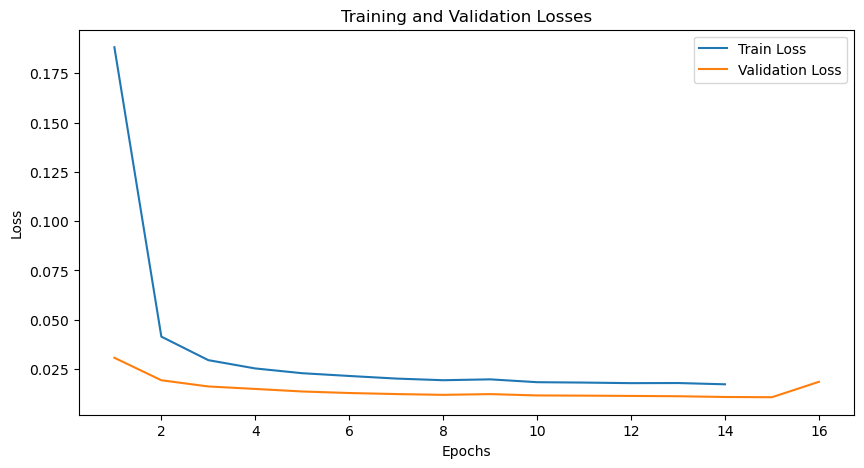

In [12]:

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# After training completes, load the best model to use for predictions
#loading the model
#best_model = load_model('model_checkpoint.pth')
best_model = torch.load('model_checkpoint.pth')
model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

In [15]:
#Use model to predic
model.eval()
# Get a single example from the test loader
test_images = next(iter(test_loader))
inputs, true_labels = test_images['image'].float().cuda(), test_images['label'].float().cuda()
with torch.no_grad():
    outputs = model(inputs)


Inspect output of best model

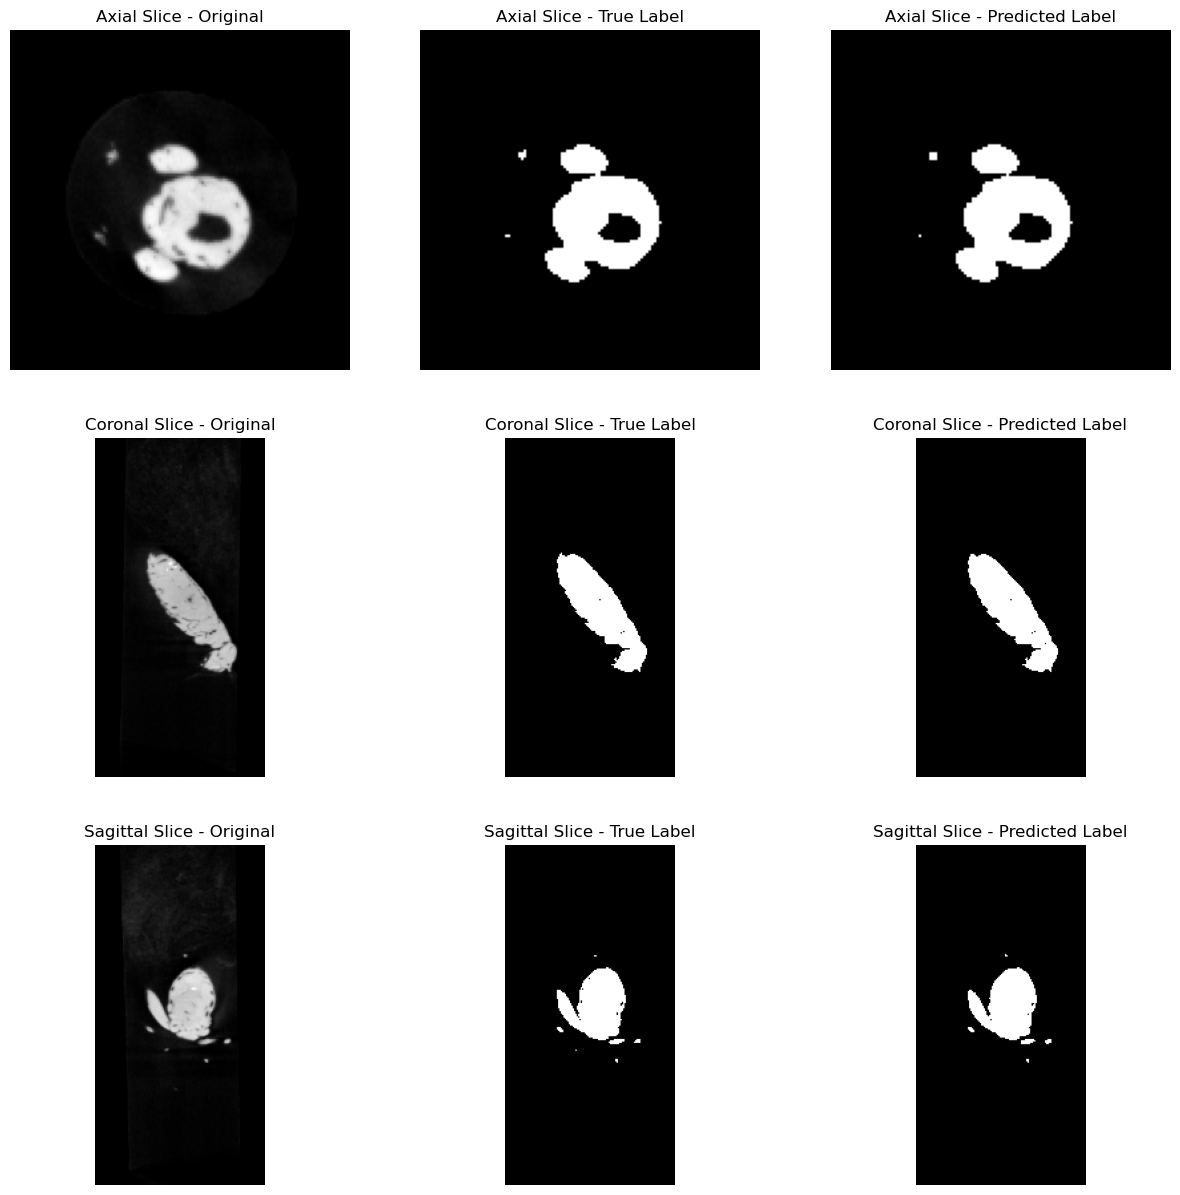

In [16]:
#------Visualize the predicted model------
# Convert predictions from probabilities and remove batch dimension
_, predicted_labels = torch.max(outputs, 1)
predicted_labels = predicted_labels.squeeze().cpu().numpy()

# Also, remove batch dimension from inputs and labels if present
inputs = inputs.squeeze().cpu().numpy()
true_labels = true_labels.squeeze().cpu().numpy()

# Selecting the middle slices for a good view, adjust indices as needed
axial_slice = predicted_labels.shape[0] // 2
coronal_slice = predicted_labels.shape[1] // 2
sagittal_slice = predicted_labels.shape[2] // 2

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Displaying original image slices
axes[0, 0].imshow(inputs[axial_slice], cmap='gray')
axes[0, 0].set_title('Axial Slice - Original')
axes[1, 0].imshow(inputs[:, coronal_slice, :], cmap='gray')
axes[1, 0].set_title('Coronal Slice - Original')
axes[2, 0].imshow(inputs[:, :, sagittal_slice], cmap='gray')
axes[2, 0].set_title('Sagittal Slice - Original')

# Displaying true label slices
axes[0, 1].imshow(true_labels[axial_slice], cmap='gray')
axes[0, 1].set_title('Axial Slice - True Label')
axes[1, 1].imshow(true_labels[:, coronal_slice, :], cmap='gray')
axes[1, 1].set_title('Coronal Slice - True Label')
axes[2, 1].imshow(true_labels[:, :, sagittal_slice], cmap='gray')
axes[2, 1].set_title('Sagittal Slice - True Label')

# Displaying predicted label slices
axes[0, 2].imshow(predicted_labels[axial_slice], cmap='gray')
axes[0, 2].set_title('Axial Slice - Predicted Label')
axes[1, 2].imshow(predicted_labels[:, coronal_slice, :], cmap='gray')
axes[1, 2].set_title('Coronal Slice - Predicted Label')
axes[2, 2].imshow(predicted_labels[:, :, sagittal_slice], cmap='gray')
axes[2, 2].set_title('Sagittal Slice - Predicted Label')

for ax in axes.flatten():
    ax.axis('off')


In [17]:
# Resize or crop the predicted labels to match the desired dimensions (64, 32, 32)
# For this example, let's use slicing to crop, adjust this based on how your data needs to fit the target size
# Make sure your original data dimensions allow this operation without error
#from skimage.transform import resize

#desired_shape = (256, 128, 128)
#cropped_predicted_labels = resize(predicted_labels, desired_shape, order=1, preserve_range=True, anti_aliasing=True)

# Convert binary mask to grayscale by multiplying by 255
# Assuming cropped_predicted_labels is a binary mask with values 0 or 1
grayscale_predicted_labels = (predicted_labels * 255).astype(np.uint8)

# Save the array as a TIFF file
file_path = 'Output_segmention/Improved_predicted_labels_031_1.tif'
tiff.imwrite(file_path, grayscale_predicted_labels)
print("Saved predicted labels as grayscale TIFF at:", file_path)


Saved predicted labels as grayscale TIFF at: Output_segmention/Improved_predicted_labels_031_1.tif
